In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import scipy.stats as stats
import pickle
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
def logbook_to_csv(pickle_path):
    # Load the Logbook data from the pickle file
    with open(pickle_path, "rb") as f:
        big_logbook = pickle.load(f)

    # Initialize lists to store extracted data
    fitness_avg = []
    fitness_std = []
    fitness_max = []
    runs = []
    generations = []

    # Initialize variables to keep track of the current run and generation
    current_run = None
    current_generation = 0

    # Loop through the Logbook to extract data
    for i, record in enumerate(big_logbook):
        # Check if the run has changed
        new_run = record.get('Run', 'Unknown')
        if new_run != current_run:
            current_run = new_run
            current_generation = 0  # Reset the generation counter

        # Increment the current generation
        current_generation += 1

        # Store the data
        fitness_avg.append(record['Fitness avg'])
        fitness_std.append(record['Fitness std'])
        fitness_max.append(record['Fitness max'])
        runs.append(current_run)
        generations.append(current_generation)

    # Create a DataFrame
    df_logbook = pd.DataFrame({
        'Run': runs,
        'Generation': generations,
        'Fitness Avg': fitness_avg,
        'Fitness Std': fitness_std,
        'Fitness Max': fitness_max
    })

    return df_logbook

def info_dict_to_dataframe(pickle_file):

    with open(pickle_file, "rb") as f:
        info_dict = pickle.load(f)

    # Initialize a dictionary to hold the average values
    info_dict_avg = {}

    # Calculate average values for each run and each enemy
    for run, enemies in info_dict.items():
        info_dict_avg[run] = {}
        for enemy, data in enemies.items():
            avg_gain = np.mean(data['gain'])
            avg_victory = np.mean(data['victory'])
            avg_fitness = np.mean(data['fitness'])
            info_dict_avg[run][enemy] = {'gain': avg_gain, 'victory': avg_victory, 'fitness': avg_fitness}

    # Initialize lists to hold DataFrame data
    runs = []
    enemies = []
    gains = []
    victories = []
    fitnesses = []

    # Loop through info_dict_avg to extract data
    for run, run_data in info_dict_avg.items():
        for enemy, enemy_data in run_data.items():
            runs.append(run)
            enemies.append(enemy)
            gains.append(enemy_data['gain'])
            victories.append(enemy_data['victory'])
            fitnesses.append(enemy_data['fitness'])

    # Create and return a DataFrame
    df_info = pd.DataFrame({
        'Run': runs,
        'Enemy': enemies,
        'Gains': gains,
        'Victories': victories,
        'Fitness': fitnesses
    })

    return df_info

# load and create dataframe for c_147
info_dict_NSGA_147_path = "info_dict_NSGA_147(2).pkl"
df_info_NSGA147 = info_dict_to_dataframe(info_dict_NSGA_147_path)


<div class="alert alert-block alert-success">
<b> ------------- Loading the Data Sets -------------------</b>
</div>

In [4]:
big_logbook_c_147 = logbook_to_csv("big_logbook_c_147.pkl")
df_info_c_147 = info_dict_to_dataframe("info_dict_c_147.pkl")

big_logbook_c_78 = logbook_to_csv("big_logbook_c_78.pkl")
df_info_c_78 = info_dict_to_dataframe("info_dict_c_78.pkl")


df_info_NSGA_147 = info_dict_to_dataframe("info_dict_NSGA_147.pkl")
df_info_NSGA_78 = info_dict_to_dataframe("info_dict_NSGA_78.pkl")

<div class="alert alert-block alert-success">
<b> ------------- Start to Make Plots -------------------</b>

Notice that I did not make a plot of fitness vs generation for NSGA_III, becasue the fitness functions is different from the default one, and it is multi-objective.
</div>

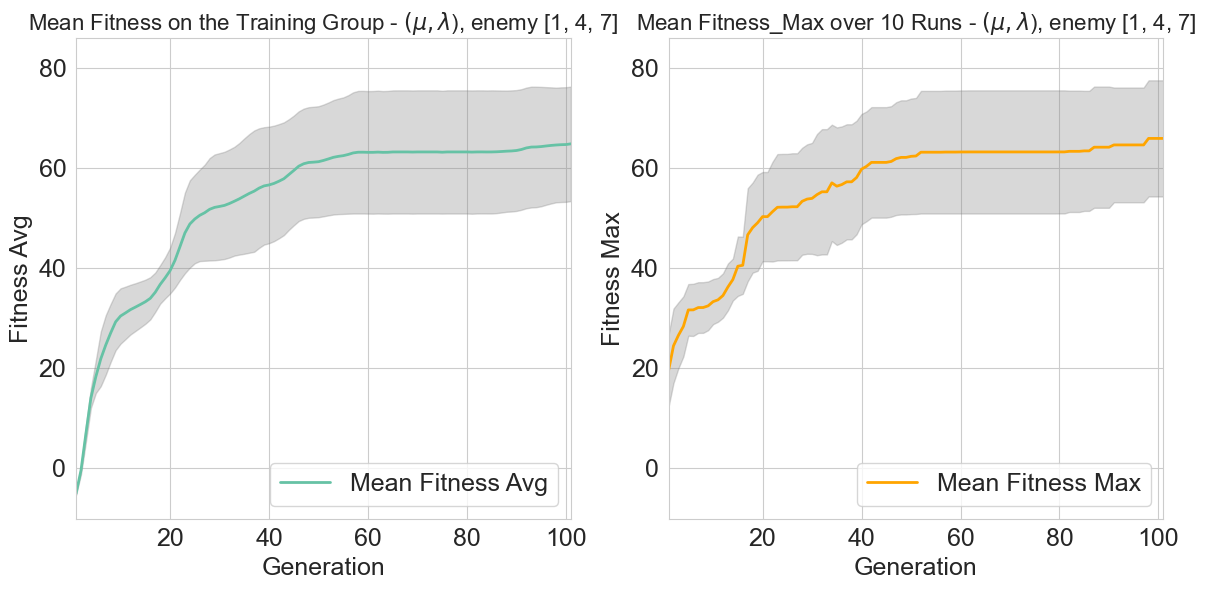

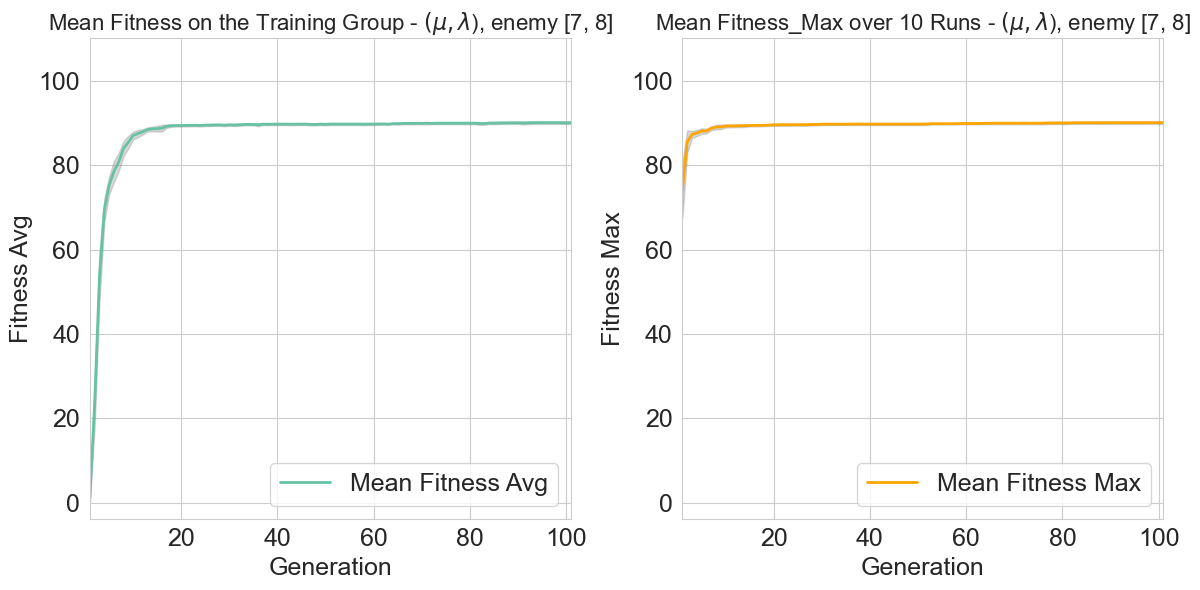

In [5]:
def plot_fitness_data(df, data_name):
    '''
    This function plots the Fitness Avg and Fitness Max data from a DataFrame, grouped by generation.
    The DataFrame should have the following columns:
    - Run
    - Generation
    - Fitness Avg
    - Fitness Std
    - Fitness Max

    The function will calculate the mean and 95% confidence intervals for Fitness Avg and Fitness Max
    over the 10 runs over enemies in a TRAINING SET, and plot them in a line plot.

    '''

    sns.set_style("whitegrid")
    sns.set_palette("Set2")

    grouped = df.groupby('Generation').agg({'Fitness Avg': ['mean', 'sem'], 'Fitness Max': ['mean', 'sem']})

    # Calculate 95% confidence intervals
    ci95_coef = stats.t.ppf((1 + 0.95) / 2., df['Run'].nunique()-1)
    grouped['Fitness Avg', 'ci95'] = grouped['Fitness Avg', 'sem'] * ci95_coef
    grouped['Fitness Max', 'ci95'] = grouped['Fitness Max', 'sem'] * ci95_coef

    # Create line plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Determine the axis limits for uniformity
    x_min, x_max = grouped.index.min(), grouped.index.max()
    y_min = min(grouped['Fitness Avg', 'mean'].min(), grouped['Fitness Max', 'mean'].min()) - 5
    y_max = max(grouped['Fitness Avg', 'mean'].max(), grouped['Fitness Max', 'mean'].max()) + 20

    for ax in axes:
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])

    # Plot for Fitness Avg
    axes[0].plot(grouped.index, grouped['Fitness Avg', 'mean'], label='Mean Fitness Avg', linewidth=2)
    axes[0].fill_between(grouped.index,
                         grouped['Fitness Avg', 'mean'] - grouped['Fitness Avg', 'ci95'],
                         grouped['Fitness Avg', 'mean'] + grouped['Fitness Avg', 'ci95'],
                         color='gray', alpha=0.3)
    axes[0].set_title(f'Mean Fitness on the Training Group - {data_name}', fontsize=16)
    axes[0].set_xlabel('Generation', fontsize=18)
    axes[0].set_ylabel('Fitness Avg', fontsize=18)
    axes[0].tick_params(axis='both', which='major', labelsize=18)
    axes[0].legend(fontsize=18, loc='lower right')

    # Plot for Fitness Max
    axes[1].plot(grouped.index, grouped['Fitness Max', 'mean'], label='Mean Fitness Max', color='orange', linewidth=2)
    axes[1].fill_between(grouped.index,
                         grouped['Fitness Max', 'mean'] - grouped['Fitness Max', 'ci95'],
                         grouped['Fitness Max', 'mean'] + grouped['Fitness Max', 'ci95'],
                         color='gray', alpha=0.3)
    axes[1].set_title(f'Mean Fitness_Max over 10 Runs - {data_name}', fontsize=16)
    axes[1].set_xlabel('Generation', fontsize=18)
    axes[1].set_ylabel('Fitness Max', fontsize=18)
    axes[1].tick_params(axis='both', which='major', labelsize=18)
    axes[1].legend(fontsize=18, loc='lower right')

    plt.tight_layout()
    plt.show()


plot_fitness_data(big_logbook_c_147, f'$(\mu, \lambda$), enemy [1, 4, 7]')
plot_fitness_data(big_logbook_c_78, f'$(\mu, \lambda$), enemy [7, 8]')


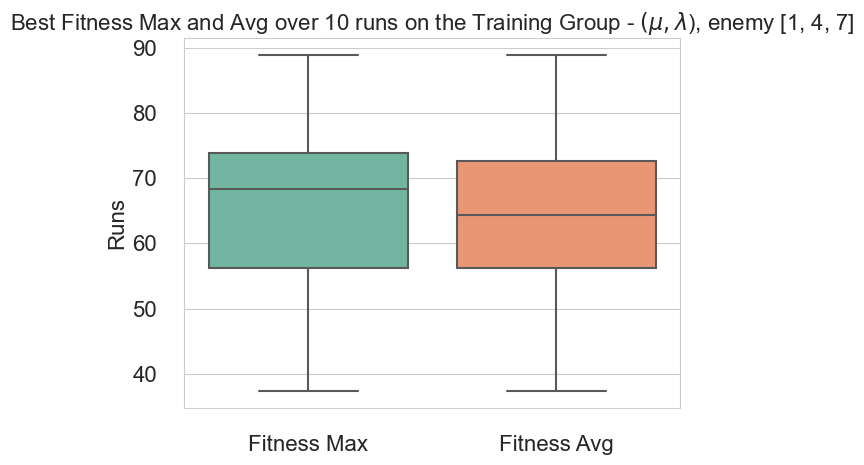

In [6]:
def plot_boxplot_fitness(df, data_name):
    '''
    This function plots the Fitness Max and Fitness Avg data from a DataFrame, grouped by run.
    The DataFrame should have the following columns:
    - Run
    - Generation
    - Fitness Avg
    - Fitness Std
    - Fitness Max

    The function will create a boxplot for Fitness Max and Fitness Avg over the 10 runs.
    '''

    df_max = df.groupby('Run').max()

    # Create the boxplot
    sns.boxplot(data=df_max[['Fitness Max', 'Fitness Avg']])
    plt.title(f'Best Fitness Max and Avg over 10 runs on the Training Group - {data_name}', fontsize=16)
    plt.ylabel('Runs', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tick_params(axis='both', which='major', pad=16)
    plt.show()


plot_boxplot_fitness(big_logbook_c_147, f'$(\mu, \lambda$), enemy [1, 4, 7]')





In [7]:
def plot_metrics(df, data_name):
    df_info_sum = df.groupby('Run')[['Gains', 'Victories']].sum().reset_index()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Boxplot for Gains
    sns.boxplot(y='Gains', data=df_info_sum, showmeans=True, meanline=True, ax=axes[0])
    axes[0].axhline(df_info_sum['Gains'].mean(), color='purple', linestyle='--', linewidth=1.5, label='Mean')
    axes[0].axhline(df_info_sum['Gains'].median(), color='red', linestyle='-', linewidth=1.5, label='Median')
    axes[0].set_title(f'Boxplot of Gains by Run - {data_name}', fontsize=18)
    axes[0].set_ylabel('Total Gains', fontsize=16)
    axes[0].tick_params(axis='both', which='major', labelsize=16)
    axes[0].legend(fontsize='x-large')

    # Boxplot for Victories
    sns.boxplot(y='Victories', data=df_info_sum, showmeans=True, meanline=True, ax=axes[1])
    axes[1].axhline(df_info_sum['Victories'].mean(), color='purple', linestyle='--', linewidth=1.5, label='Mean')
    axes[1].axhline(df_info_sum['Victories'].median(), color='red', linestyle='-', linewidth=1.5, label='Median')
    axes[1].set_title(f'Boxplot of Victories by Run - {data_name}', fontsize=18)
    axes[1].set_ylabel('Total Victories', fontsize=16)
    axes[1].tick_params(axis='both', which='major', labelsize=16)
    axes[1].legend(fontsize='x-large', loc='upper right')

    # Boxplot for Fitness
    sns.boxplot(y='Fitness', data=df, showmeans=True, meanline=True, ax=axes[2])
    axes[2].axhline(df['Fitness'].mean(), color='purple', linestyle='--', linewidth=1.5, label='Mean')
    axes[2].axhline(df['Fitness'].median(), color='red', linestyle='-', linewidth=1.5, label='Median')
    axes[2].set_title(f'Boxplot of Fitness by Run - {data_name}', fontsize=18)
    axes[2].set_ylabel('Fitness', fontsize=16)
    axes[2].tick_params(axis='both', which='major', labelsize=16)
    axes[2].legend(fontsize='x-large', loc='upper right')

    plt.tight_layout()
    plt.show()


<div class="alert alert-block alert-warning">
<b> -------------!!! Do not Forget to Uncomment the Code, If Needed !!! -------------------</b>
</div>

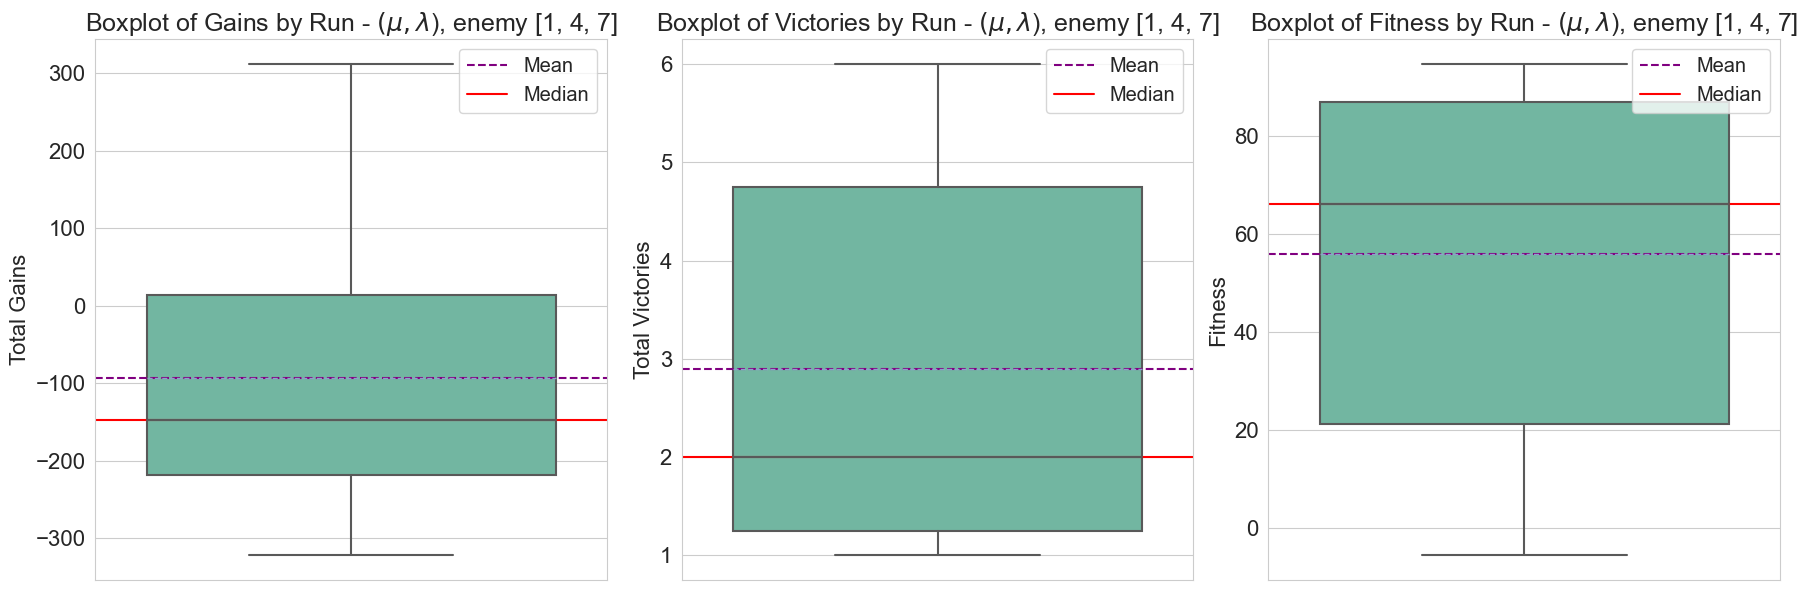

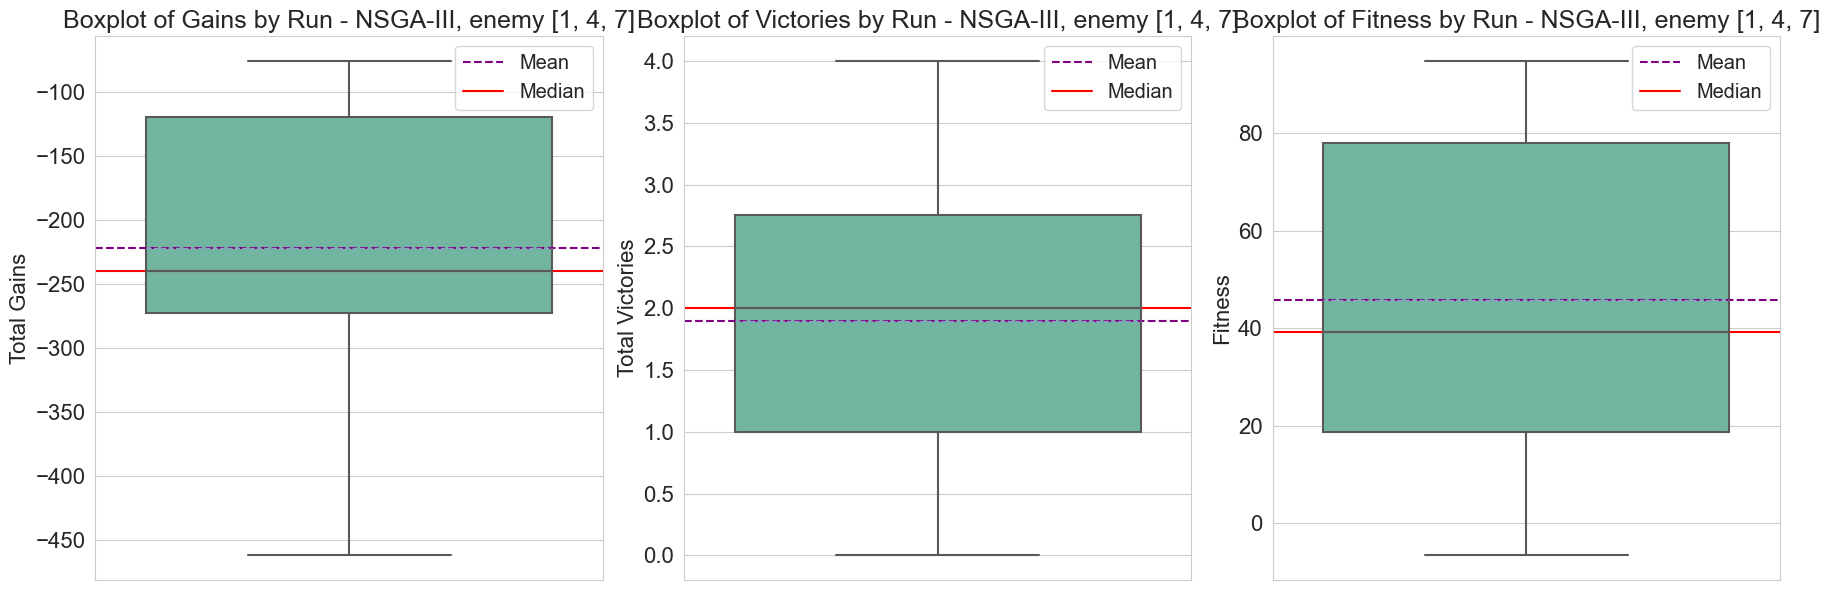

In [8]:
plot_metrics(df_info_c_147, f'$(\mu, \lambda$), enemy [1, 4, 7]')
# plot_metrics(df_info_c_78, f'$(\mu, \lambda$), enemy [7, 8]')

plot_metrics(df_info_NSGA_147, f'NSGA-III, enemy [1, 4, 7]')
# plot_metrics(df_info_NSGA_78, f'NSGA-III, enemy [7, 8]')




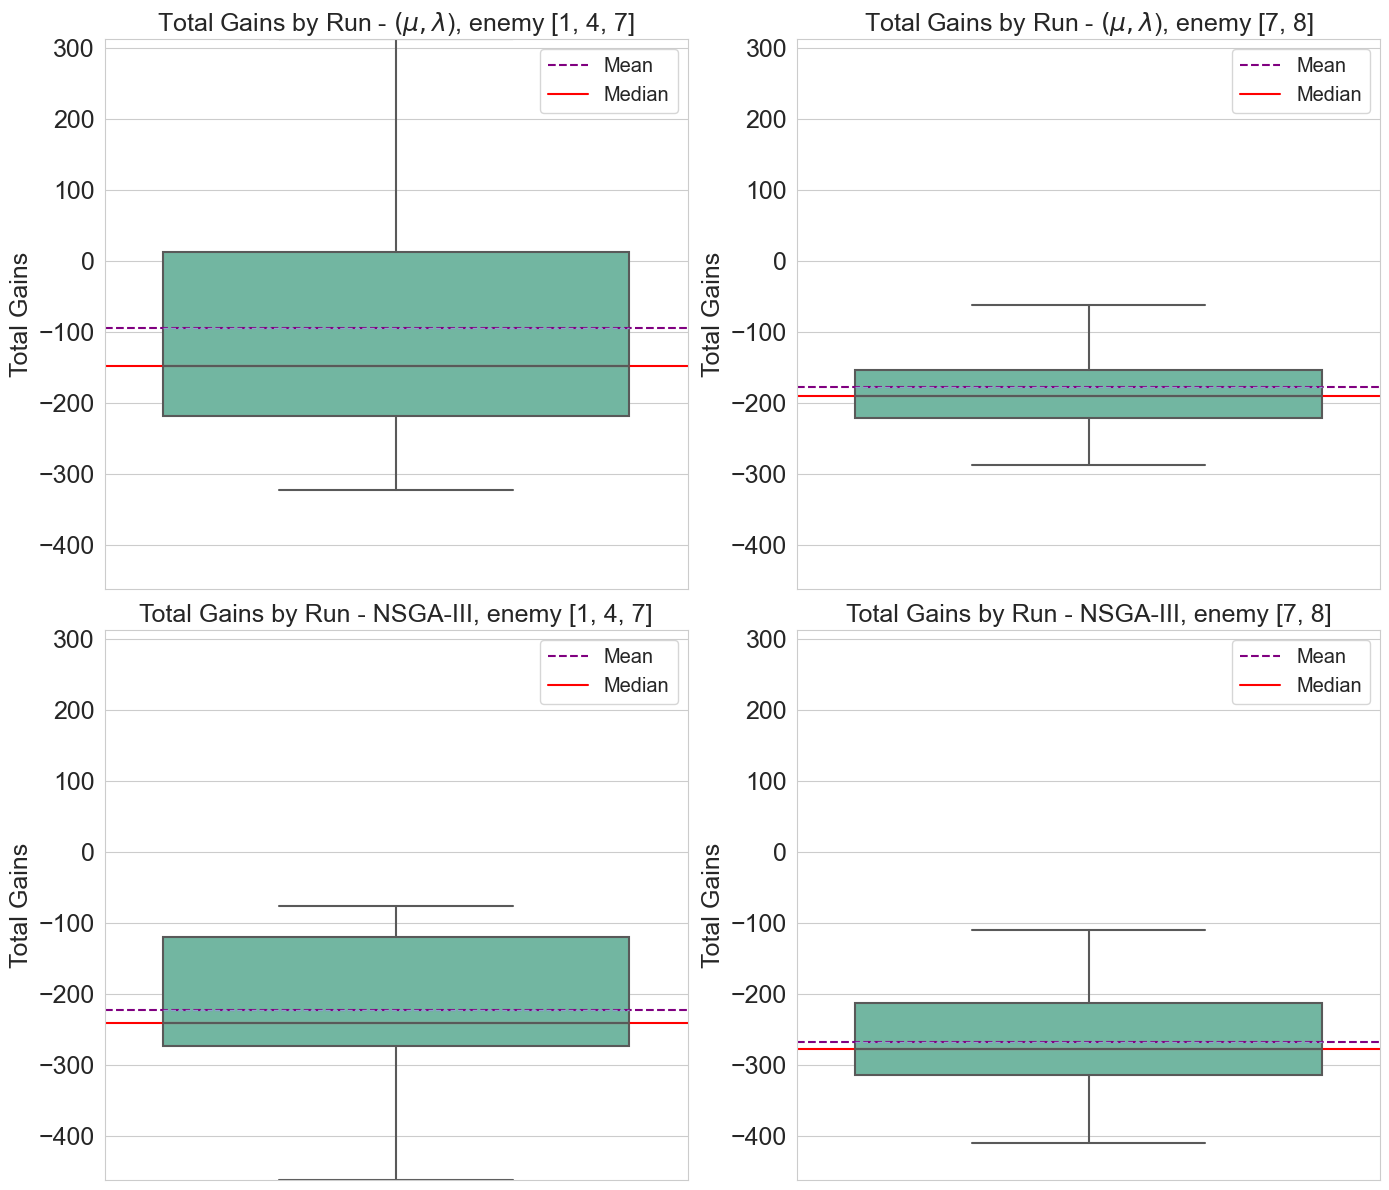

In [9]:
def plot_total_gains_2x2(df1, df2, df3, df4, names):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    data_frames = [df1, df2, df3, df4]
    
    # Initialize variables to store min and max y-values across all datasets
    y_min = float('inf')
    y_max = float('-inf')

    # First pass to determine the global min and max
    for df in data_frames:
        df_sum = df.groupby('Run')['Gains'].sum().reset_index()
        local_min = df_sum['Gains'].min()
        local_max = df_sum['Gains'].max()
        
        if local_min < y_min:
            y_min = local_min
        if local_max > y_max:
            y_max = local_max

    # Second pass to actually plot
    for ax, df, name in zip(axes.flatten(), data_frames, names):
        df_sum = df.groupby('Run')['Gains'].sum().reset_index()
        sns.boxplot(y='Gains', data=df_sum, showmeans=True, meanline=True, ax=ax)
        
        # Synchronize y-axis limits
        ax.set_ylim(y_min, y_max)

        ax.axhline(df_sum['Gains'].mean(), color='purple', linestyle='--', linewidth=1.5, label='Mean')
        ax.axhline(df_sum['Gains'].median(), color='red', linestyle='-', linewidth=1.5, label='Median')
        ax.set_title(f'Total Gains by Run - {name}', fontsize=18)
        ax.set_ylabel('Total Gains', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.legend(fontsize='x-large')

    plt.tight_layout()
    plt.show()

plot_total_gains_2x2(df_info_c_147, df_info_c_78, df_info_NSGA_147, df_info_NSGA_78,
                        [r'$(\mu, \lambda$), enemy [1, 4, 7]', r'$(\mu, \lambda$), enemy [7, 8]',
                        'NSGA-III, enemy [1, 4, 7]', 'NSGA-III, enemy [7, 8]'])

In [11]:
def plot_enemy_avg_fitness(df, data_name):
    # Group the data by Enemy and take the mean of the Fitness values
    df_grouped = df.groupby(['Enemy'])['Fitness'].mean().reset_index()

    # Create the histogram
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Enemy', y='Fitness', data=df_grouped)

    # Add a horizontal line at y=50 as the fitness benchmark
    plt.axhline(y=50, color='r', linestyle='--', label='Benchmark (Fitness = 50)')

    # Add titles and labels
    plt.title(f'Average Fitness by Enemy Over 10 Runs - {data_name}', fontsize=18)
    plt.xlabel('Enemy', fontsize=16)
    plt.ylabel('Average Fitness', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize='x-large', loc='upper right')

    plt.show()

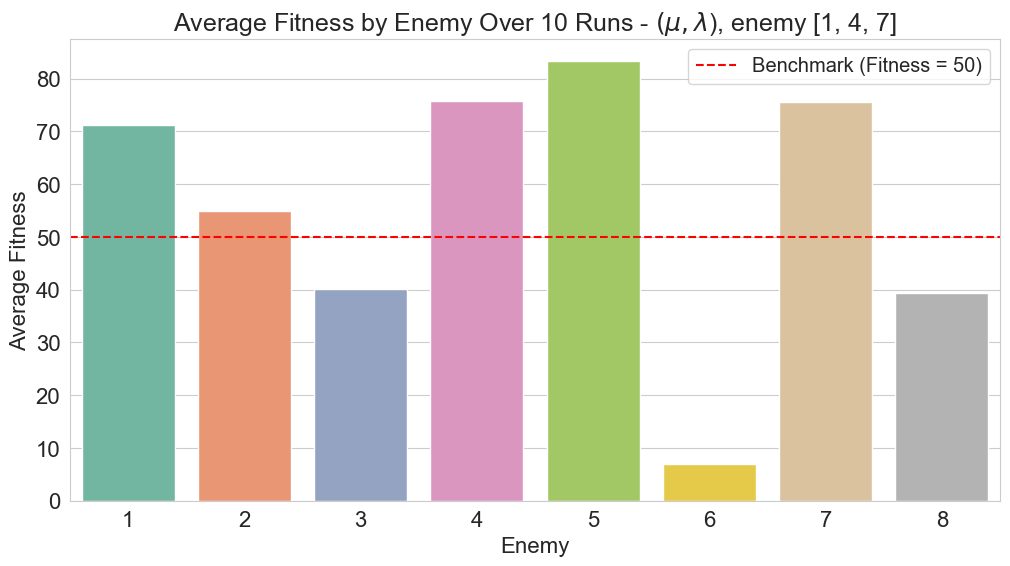

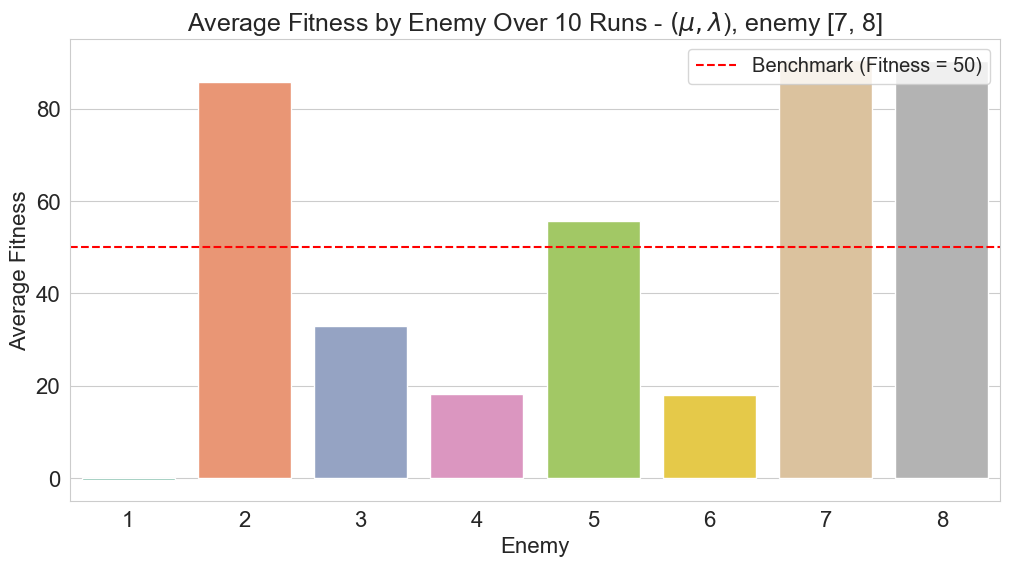

In [12]:
plot_enemy_avg_fitness(df_info_c_147, f'$(\mu, \lambda$), enemy [1, 4, 7]')
plot_enemy_avg_fitness(df_info_c_78, f'$(\mu, \lambda$), enemy [7, 8]')

# plot_enemy_avg_fitness(df_info_NSGA_147, f'NSGA-III, enemy [1, 4, 7]')
# plot_enemy_avg_fitness(df_info_NSGA_78, f'NSGA-III, enemy [7, 8]')

<div class="alert alert-block alert-success">
<b> ------------------------- Statistical Tests -----------------------------</b>
</div>

In [13]:
import scipy.stats as stats

def check_significance_by_enemy(df1, df2, algorithm_name):
    # Group data by 'Run' and sum the gains
    df1_sum = df1.groupby('Run')['Gains'].sum()
    df2_sum = df2.groupby('Run')['Gains'].sum()

    # Perform a one-way ANOVA test
    F, p = stats.f_oneway(df1_sum, df2_sum)

    print(f"For algorithm {algorithm_name}:")
    print(f"F-value: {F}, p-value: {p}")

    if p < 0.05:
        print("The difference in total gains between different training enemies is statistically significant.")
    else:
        print("The difference in total gains between different training enemies is not statistically significant.")


def check_significance_by_algorithm(df1, df2):
    # Concatenate the data and reset index
    df = pd.concat([df1, df2]).reset_index(drop=True)

    # Introduce a new column for the algorithm type
    df['Algorithm'] = ['Alg1']*len(df1) + ['Alg2']*len(df2)

    # Group by 'Run' and 'Algorithm' and sum the gains
    df_sum = df.groupby(['Run', 'Algorithm'])['Gains'].sum().reset_index()

    # Perform a two-way ANOVA
    model = ols("Gains ~ C(Run) + C(Algorithm)", data=df_sum).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print("Two-way ANOVA Table:")
    print(anova_table)

    p_algorithm = anova_table.loc['C(Algorithm)', 'PR(>F)']

    if p_algorithm < 0.05:
        print("The algorithms are significantly different from each other in terms of total gain.")
    else:
        print("The algorithms are not significantly different from each other in terms of total gain.")


# ------------------------------------------- Statistical Analysis Results------------------------------------------- #

print('\nStatistical Analysis Results for (mu,lambda) enemies 147 vs (mu,lambda) enemies 78: ')
print()
check_significance_by_enemy(df_info_c_147, df_info_c_78, "c_algorithm")

print('\nStatistical Analysis Results for NSGA-III enemies 147 vs NSGA-III enemies 78: ')
print()
check_significance_by_enemy(df_info_NSGA_147, df_info_NSGA_78, "NSGA-III")

print('\nStatistical Analysis Results for (mu,lambda) enemies 147 vs NSGA-III enemies 147: ')
check_significance_by_algorithm(df_info_c_147, df_info_NSGA_147)

print('\nStatistical Analysis Results for (mu,lambda) enemies 78 vs NSGA-III enemies 78: ')
check_significance_by_algorithm(df_info_c_78, df_info_NSGA_78)






Statistical Analysis Results for (mu,lambda) enemies 147 vs (mu,lambda) enemies 78: 

For algorithm c_algorithm:
F-value: 1.6010479178242265, p-value: 0.22188986368592872
The difference in total gains between different training enemies is not statistically significant.

Statistical Analysis Results for NSGA-III enemies 147 vs NSGA-III enemies 78: 

For algorithm NSGA-III:
F-value: 0.9574235621660843, p-value: 0.34080563061508623
The difference in total gains between different training enemies is not statistically significant.

Statistical Analysis Results for (mu,lambda) enemies 147 vs NSGA-III enemies 147: 
Two-way ANOVA Table:
                  sum_sq   df         F    PR(>F)
C(Run)        341326.762  9.0  2.591449  0.086124
C(Algorithm)   82048.050  1.0  5.606386  0.042062
Residual      131712.730  9.0       NaN       NaN
The algorithms are significantly different from each other in terms of total gain.

Statistical Analysis Results for (mu,lambda) enemies 78 vs NSGA-III enemies 78